# Hyperparameter Optimization Of TemporalFusionTransformer

In [7]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from autogluon.timeseries import TimeSeriesPredictor, TimeSeriesDataFrame

In [8]:
# Load data of closing transaction
df = pd.read_csv('../CSV/df_TS_week.csv')
df.head()

,item_id,timestamp,ACT01,ACT03,ACT04,ACT07,ACT09,ACT13,ACT15,ACT17,ACT32,ACT44,target
0,FR13,2019-12-30,1267.0,299.0,0.0,2108.0,189.0,84.0,0.0,0.0,3716.0,0.0,7663.0
1,FR13,2020-01-06,1052.0,490.0,2.0,103.0,255.0,191.0,3.0,0.0,821.0,0.0,2917.0
2,FR13,2020-01-13,846.0,115.0,0.0,280.0,69.0,66.0,416.0,407.0,142.0,0.0,2341.0
3,FR13,2020-01-20,1350.0,932.0,44.0,568.0,297.0,278.0,81.0,80.0,223.0,0.0,3853.0
4,FR13,2020-01-27,1871.0,863.0,0.0,609.0,363.0,219.0,2.0,0.0,19393.0,58931.0,82251.0


In [9]:
# Create a new df of the item_id equal to IT01 
df_IT = df[df['item_id'] == 'IT01']
print(df_IT.shape)

(172, 13)


In [10]:
# Drop ACT04 column
df_IT = df_IT.drop(columns=['ACT04'])

In [11]:
# Split data into training and testing set; train set based on timestamp from 2020-01-01 to 2022-04-30 and test set based on timestamp from 2022-05-01 to 2023-04-30
train_data = df_IT[df_IT['timestamp'] <= '2022-04-30']
test_data = df_IT[df_IT['timestamp'] > '2022-04-30']

# Calculate the percentage of the training set and testing set
print(train_data.shape[0] / df_IT.shape[0])
print(test_data.shape[0] / df_IT.shape[0])

0.6976744186046512
0.3023255813953488


In [12]:
# Convert train_data to TimeSeriesDataFrame
train_data = TimeSeriesDataFrame(
    train_data, 
    id_column="item_id",
    timestamp_column="timestamp"
    
)

train_data.head()

ACT01  ACT03  ACT07  ACT09  ACT13   ACT15   ACT17  \
item_id timestamp                                                        
IT01    2019-12-30  1228.0   87.0  195.0  188.0   32.0  1817.0  1255.0   
        2020-01-06    87.0   63.0    5.0    8.0    0.0     0.0     0.0   
        2020-01-13   161.0   10.0   14.0    0.0   49.0     1.0     0.0   
        2020-01-20   437.0  143.0   86.0   67.0  110.0     0.0     0.0   
        2020-01-27   403.0  457.0  178.0  108.0   48.0     7.0     0.0   

                     ACT32  ACT44  target  
item_id timestamp                          
IT01    2019-12-30  2811.0    0.0  7613.0  
        2020-01-06   227.0    0.0   390.0  
        2020-01-13   467.0    0.0   702.0  
        2020-01-20    98.0    0.0   941.0  
        2020-01-27   269.0    0.0  1470.0

In [13]:
# Convert test_data to TimeSeriesDataFrame
test_data = TimeSeriesDataFrame(
    test_data, 
    id_column="item_id",
    timestamp_column="timestamp"
    
)

test_data.head()

ACT01  ACT03  ACT07  ACT09  ACT13  ACT15  ACT17   ACT32  \
item_id timestamp                                                             
IT01    2022-05-02  788.0   29.0  396.0   30.0  111.0  515.0  145.0  2060.0   
        2022-05-09  137.0    0.0  124.0    0.0    0.0    0.0    0.0   495.0   
        2022-05-16  153.0   27.0   76.0    2.0   24.0    0.0    0.0   157.0   
        2022-05-23  452.0   28.0  387.0   57.0  158.0  506.0  138.0   352.0   
        2022-05-30  912.0  198.0  514.0  178.0  261.0   14.0   10.0  1796.0   

                    ACT44  target  
item_id timestamp                  
IT01    2022-05-02    0.0  4074.0  
        2022-05-09    0.0   756.0  
        2022-05-16    0.0   439.0  
        2022-05-23    0.0  2078.0  
        2022-05-30    0.0  3883.0

In [14]:
# Add log_target column to train_data and test_data
#train_data['log_target'] = np.log(train_data['target'])
#test_data['log_target'] = np.log(test_data['target'])

In [15]:
# Build predictor
predictor = TimeSeriesPredictor(
    prediction_length=12,
    freq='W-MON',
    target='target',
    path='C:\\Develop\\HPO_TemporalFusionTransformer',
    eval_metric='MASE'
)

In [16]:
from autogluon.common import space

# Fit the model
predictor.fit(
    train_data,
    hyperparameters = {
        "TemporalFusionTransformer": {
           "hidden_dim": space.Categorical(32, 64, 128),  
           "variable_dim": space.Categorical(32, 64, 128),
           "num_heads": space.Int(2,8),
           "dropout_rate": space.Real(0.1, 0.9),
           "max_epochs": space.Categorical(100, 150, 200),
           "batch_size": space.Categorical(64, 128, 256),
           "lr": space.Categorical(0.01, 0.001, 0.0001)
        },
    },
    hyperparameter_tune_kwargs="auto",
    num_val_windows=5,
    random_seed=42
)

In [ ]:
# Make prediction on training data
predictions = predictor.predict(train_data, random_seed=42)
predictions.head()

data with frequency 'None' has been resampled to frequency 'W-MON'.


data contains missing values represented by NaN. They have been filled by carrying forward the last valid observation.


mean          0.1          0.2          0.3  \
item_id timestamp                                                        
IT01    2022-05-02  4524.142090  4070.537109  4080.585449  4196.431641   
        2022-05-09   798.846802  -179.332031   265.862061   452.809814   
        2022-05-16   805.398926   -33.829590   369.190918   542.372681   
        2022-05-23  1087.836182   341.562256   815.523071   978.999268   
        2022-05-30  4348.063477  3611.051270  3922.581299  4133.615723   

                            0.4          0.5          0.6          0.7  \
item_id timestamp                                                        
IT01    2022-05-02  4258.991211  4524.142090  4434.110840  4721.583984   
        2022-05-09   484.891968   798.846802   704.880371  1153.341553   
        2022-05-16   527.221558   805.398926   835.539429  1118.380249   
        2022-05-23   894.682495  1087.836182  1143.995605  1301.401489   
        2022-05-30  4082.462402  4348.063477  4084.911621  4419.547852   

                            0.8          0.9  
item_id timestamp                             
IT01    2022-05-02  4690.747559  4771.761719  
        2022-05-09  1394.145874  1473.928589  
        2022-05-16  1339.646484  1506.384521  
        2022-05-23  1527.108643  1786.040283  
        2022-05-30  4498.168457  4592.774414

In [ ]:
predictor.leaderboard(test_data)

Additional data provided, testing on additional data. Resulting leaderboard will be sorted according to test score (`score_test`).


,model,score_test,score_val,pred_time_test,pred_time_val,fit_time_marginal,fit_order
0,WeightedEnsemble,-0.232979,-0.537601,0.061253,0.001508,6.399378,12
1,TemporalFusionTransformer,-0.232979,-0.537601,0.051451,0.001508,660.441870,10
2,NPTS,-0.291218,-0.861174,0.048777,0.033120,0.200087,3
3,PatchTST,-0.296360,-0.741395,0.094108,0.000000,136.093435,11
4,DirectTabular,-0.379798,-0.819791,0.118009,0.083276,2.399835,8
5,DeepAR,-0.566756,-0.996613,0.103765,0.060595,224.406457,9
6,CrostonSBA,-0.836662,-0.905811,10.340248,0.033796,33.966644,2
7,DynamicOptimizedTheta,-0.843813,-0.913061,18.538155,0.250083,46.849184,5
8,AutoETS,-1.245019,-1.040939,24.411128,0.031367,71.734277,4
9,AutoARIMA,-1.490722,-1.239598,15.557033,0.170826,47.354015,6


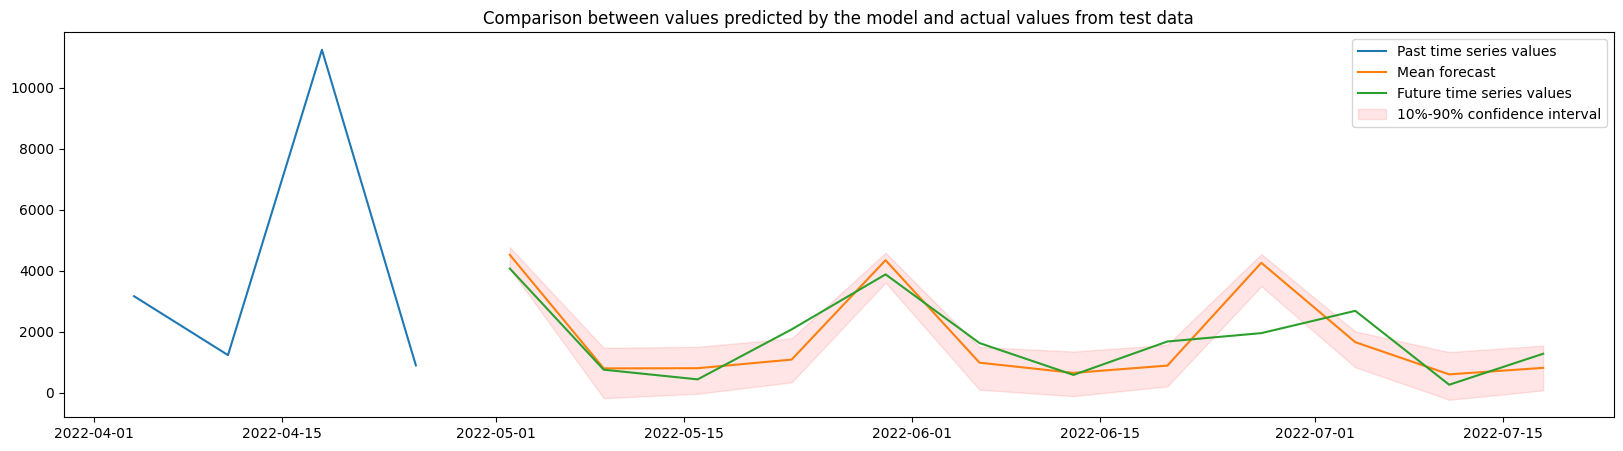

In [ ]:
plt.figure(figsize=(20, 5))
plt.title("Comparison between values predicted by the model and actual values from test data")

item_id = "IT01"
y_past = train_data.loc[item_id]["target"]
y_pred = predictions.loc[item_id]
y_test = test_data.loc[item_id]["target"][:12]

plt.plot(y_past[-4:], label="Past time series values")
plt.plot(y_pred["mean"], label="Mean forecast")
plt.plot(y_test, label="Future time series values")

plt.fill_between(
    y_pred.index, y_pred["0.1"], y_pred["0.9"], color="red", alpha=0.1, label=f"10%-90% confidence interval"
)
plt.legend()

In [ ]:
# Print all row of predictions where item_id is IT01
predictions.loc['IT01']

,mean,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9
timestamp,,,,,,,,,,
2022-05-02,4524.142090,4070.537109,4080.585449,4196.431641,4258.991211,4524.142090,4434.110840,4721.583984,4690.747559,4771.761719
2022-05-09,798.846802,-179.332031,265.862061,452.809814,484.891968,798.846802,704.880371,1153.341553,1394.145874,1473.928589
2022-05-16,805.398926,-33.829590,369.190918,542.372681,527.221558,805.398926,835.539429,1118.380249,1339.646484,1506.384521
2022-05-23,1087.836182,341.562256,815.523071,978.999268,894.682495,1087.836182,1143.995605,1301.401489,1527.108643,1786.040283
2022-05-30,4348.063477,3611.051270,3922.581299,4133.615723,4082.462402,4348.063477,4084.911621,4419.547852,4498.168457,4592.774414
2022-06-06,986.619629,99.857178,540.371582,722.387695,871.085571,986.619629,929.351196,1269.371582,1460.193604,1502.302246
2022-06-13,651.707642,-111.435547,218.072510,391.928467,512.161499,651.707642,775.926270,1052.497437,1164.438354,1350.703125
2022-06-20,890.694458,209.544678,574.277710,746.590820,790.036865,890.694458,1057.971313,1160.690552,1274.440186,1574.206543
2022-06-27,4262.916016,3494.252930,3828.604004,4067.312500,4002.496094,4262.916016,4004.703857,4404.923340,4441.751465,4546.637207


In [ ]:
# Sum all value of mean forecast of predictions where item_id is IT01
predictions.loc['IT01']['mean'].sum()

21435.705

In [ ]:
# Sum all value of target of test_data 
test_data.loc['IT01']['target'][:12].sum()

21311.0

In [ ]:
# Calculate difference betweend each prediction and actual value of test_data
diff = predictions.loc['IT01']['mean'] - test_data.loc['IT01']['target'][:12]
diff

timestamp
2022-05-02     450.142090
2022-05-09      42.846802
2022-05-16     366.398926
2022-05-23    -990.163818
2022-05-30     465.063477
2022-06-06    -643.380371
2022-06-13      66.707642
2022-06-20    -790.305542
2022-06-27    2306.916016
2022-07-04   -1027.496094
2022-07-11     339.936768
2022-07-18    -461.960693
dtype: float64